# UBC Bolt 2025 Case Competition

## Introduction

We are given a case and we are trying our best to conduct data analytics

### Key Ask

Peak Mountain Resort operates year-round, offering a range of seasonal activities that attract visitors but also introduces significant safety risks and operational challenges.  With increasing injury rates, extended emergency response times, aging infrastructure, and financial constraints, the resort must find a way to improve guest safety without compromising its budget or long-term viability.

### Key Question

**How can Peak Mountain Resort implement cost-effective, data-driven safety measures and ensure financial sustainability?**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Importing Dataset and Summary Statistics

In [2]:
expense_dat = pd.read_csv('data/expenses.csv')
expense_dat.head()

,Transaction_ID,Transaction_Type,Category,Amount,Date,Season,Weather,Customer_ID,Incident_ID
0,0,Revenue,Ticket Sale,3500,2025-02-25,Winter,Foggy,1415.0,NaN
1,1,Revenue,Ticket Sale,640,2025-02-25,Winter,Windy,5095.0,NaN
2,2,Expense,Ambulance Call,-1490,2025-02-25,Winter,Foggy,NaN,96.0
3,3,Expense,Equipment Maintenance,-730,2025-02-25,Winter,Sunny,NaN,NaN
4,4,Expense,Staff Salary,-4238,2025-02-25,Summer,Sunny,NaN,NaN


In [3]:
incident_dat = pd.read_csv('data/incidents.csv')
incident_dat.head()

,Incident_ID,Customer_ID,Age,Gender,Season,Weather,Activity,Slope_Name,Slope_Difficulty,Skill_Level,Protective_Gear,Injuries,Injury_Severity,Response_Time,Hospital_Transport,Hospital_Stay_Length
0,0,2679,33,Male,Winter,Foggy,Skiing,Bunny Hill,Easy,Beginner,Helmet,Sprain,6,15,No,0
1,1,4257,36,Female,Summer,Sunny,Hiking,Devil’s Drop,Expert,Beginner,Helmet,Fracture,6,23,No,0
2,2,7924,47,Female,Winter,Foggy,Snowboarding,Thunder Run,Advanced,Beginner,Helmet,Sprain,8,13,Yes,1
3,3,7224,56,Male,Summer,Sunny,Hiking,Thunder Run,Advanced,Intermediate,Helmet,Fracture,5,9,No,0
4,4,9785,17,Male,Summer,Windy,Climbing,Blue Ridge,Intermediate,Beginner,None,Head Injury,8,10,Yes,4


In [4]:
reviews_dat = pd.read_fwf("data/reviews.txt", header=None, names=["Review"], encoding="utf-8")
print(reviews_dat.head())

                                              Review
0  1. "Absolutely breathtaking views and fantasti...
1  2. "The lodge was cozy, and the staff was incr...
2  3. "Mountain biking trails were well-maintaine...
3  4. "Loved the guided nature walk. Learned so m...
4  5. "The zip-lining course was thrilling, and t...


## NLP Preprocessing

We need to first preprocess our text reviews data, this will include lowercasing everything, removing punctuation, tokenization, and lemmatization

In [5]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

In [6]:
# Download nlp libraries

#nltk.download("punkt")
#nltk.download("stopwords")
#nltk.download("wordnet")

In [7]:
# Initialize NLP tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [8]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower() 
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

reviews_dat["Cleaned_Review"] = reviews_dat["Review"].apply(preprocess_text)
reviews_dat.head()

,Review,Cleaned_Review
0,"1. ""Absolutely breathtaking views and fantasti...",1 absolutely breathtaking view fantastic skiin...
1,"2. ""The lodge was cozy, and the staff was incr...",2 lodge cozy staff incredibly friendly highly ...
2,"3. ""Mountain biking trails were well-maintaine...",3 mountain biking trail wellmaintained rental ...
3,"4. ""Loved the guided nature walk. Learned so m...",4 loved guided nature walk learned much local ...
4,"5. ""The zip-lining course was thrilling, and t...",5 ziplining course thrilling instructor profes...


We can then use a wordcloud to visualize common words

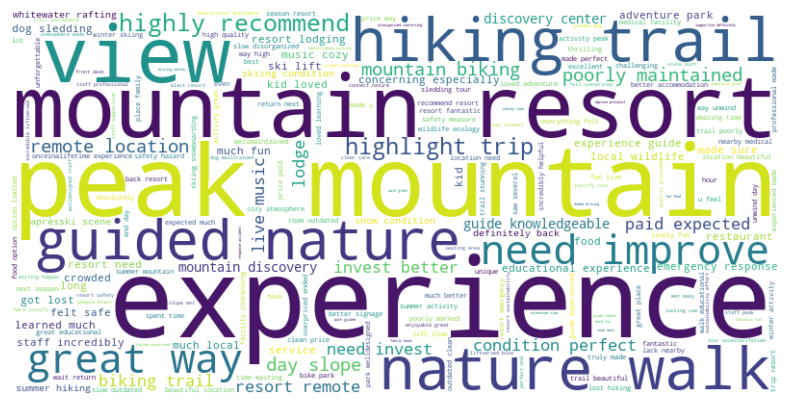

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(reviews_dat["Cleaned_Review"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From the word cloud, we see there are a lot of frequent words involving the resort in the reviews, lets run a counter to double check

In [10]:
from collections import Counter

words = " ".join(reviews_dat["Cleaned_Review"]).split()
word_freq = Counter(words).most_common(10)

print(word_freq)

[('’', 293), ('resort', 223), ('trail', 120), ('great', 103), ('mountain', 99), ('experience', 95), ('staff', 77), ('need', 77), ('activity', 72), ('made', 66)]


In [13]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Polarity score

# Apply sentiment analysis
reviews_dat["Sentiment_Polarity"] = reviews_dat["Cleaned_Review"].apply(get_sentiment)

print(reviews_dat.head())

                                              Review  \
0  1. "Absolutely breathtaking views and fantasti...   
1  2. "The lodge was cozy, and the staff was incr...   
2  3. "Mountain biking trails were well-maintaine...   
3  4. "Loved the guided nature walk. Learned so m...   
4  5. "The zip-lining course was thrilling, and t...   

                                      Cleaned_Review  Sentiment_Polarity  
0  1 absolutely breathtaking view fantastic skiin...             0.35000  
1  2 lodge cozy staff incredibly friendly highly ...             0.14625  
2  3 mountain biking trail wellmaintained rental ...             0.00000  
3  4 loved guided nature walk learned much local ...             0.35000  
4  5 ziplining course thrilling instructor profes...             0.17500  


In [14]:
#Classify Sentiment based on polarity score
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply classification
reviews_dat["Sentiment"] = reviews_dat["Sentiment_Polarity"].apply(classify_sentiment)

print(reviews_dat.head())

                                              Review  \
0  1. "Absolutely breathtaking views and fantasti...   
1  2. "The lodge was cozy, and the staff was incr...   
2  3. "Mountain biking trails were well-maintaine...   
3  4. "Loved the guided nature walk. Learned so m...   
4  5. "The zip-lining course was thrilling, and t...   

                                      Cleaned_Review  Sentiment_Polarity  \
0  1 absolutely breathtaking view fantastic skiin...             0.35000   
1  2 lodge cozy staff incredibly friendly highly ...             0.14625   
2  3 mountain biking trail wellmaintained rental ...             0.00000   
3  4 loved guided nature walk learned much local ...             0.35000   
4  5 ziplining course thrilling instructor profes...             0.17500   

  Sentiment  
0  Positive  
1  Positive  
2   Neutral  
3  Positive  
4  Positive  


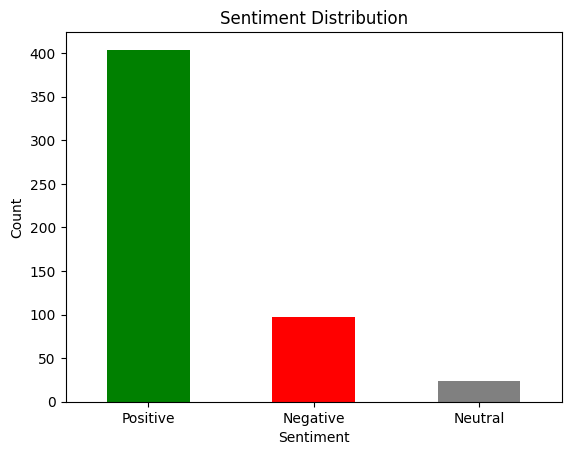

In [16]:
# Plot sentiment distribution
sentiment_counts = reviews_dat["Sentiment"].value_counts()
sentiment_counts.plot(kind="bar", color=["green", "red", "gray"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()